In [890]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17008), started 1 day, 6:02:34 ago. (Use '!kill 17008' to kill it.)

In [891]:
df = pd.read_csv('diabetes.csv')

In [892]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [893]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


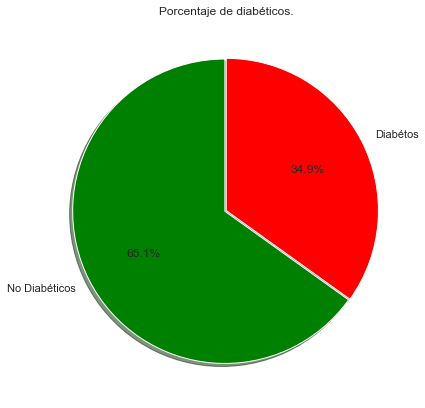

In [894]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [895]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

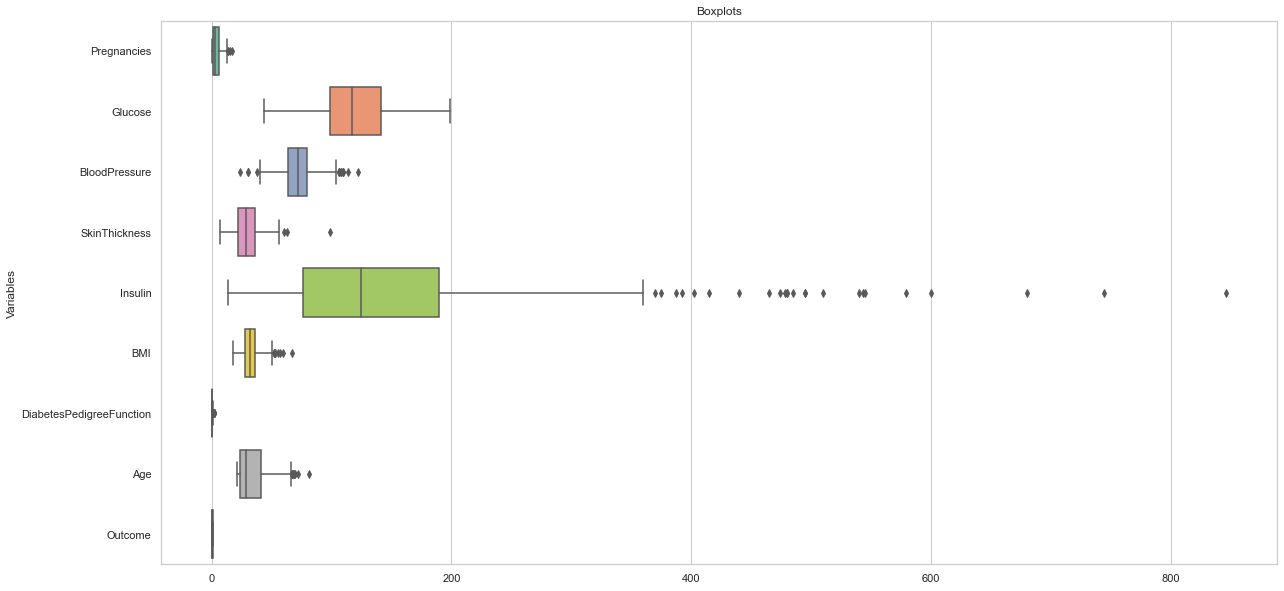

In [896]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

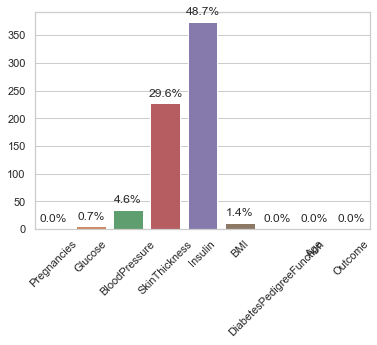

In [897]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [898]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [899]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [900]:
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.9
train_val_df = df[msk]
testData = df[~msk]

mskVal = np.random.rand(len(train_val_df)) < 0.9
trainData = train_val_df[mskVal]
validationData = train_val_df[~mskVal]


In [901]:
 def separate_data_and_labels(df):
        data = df.copy()
        y_values = data[data.columns[-1]].values.reshape(data.shape[0], 1)
        data = data.drop([data.columns[-1]], axis=1)
        return data, y_values

In [902]:
x_train_data, y_train_values = separate_data_and_labels(trainData)
x_val_data, y_val_values = separate_data_and_labels(validationData)
x_test_data, y_test_values = separate_data_and_labels(testData)

In [903]:
del(testData)
del(validationData)
del(trainData)
del(df)

In [904]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [905]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [917]:
class DiabetesPredictor:
    def __init__(self, name):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.

    """
        self.name = name

    def fit(self, train_df, y_train, val_df, y_val, replaceOutliers=False, replaceNulls=False, nullColumns=[], outliersColumnsMap={}, columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1):
        train_dataframe = train_df.copy()
        fit_df = train_dataframe.copy()

        self.columnsToRemove = columnsToRemove.copy()
        self.nullCols = nullColumns.copy()
        self.replaceNulls = replaceNulls
        self.replaceOutliers = replaceOutliers
        self.polyFeatDeg = polyFeatDeg
        self.binsDiscretizer = binsDiscretizer

        self.replace_values_nulls = []
        self.replace_values_outliers = []
        self.outliersLimits = []

        self.nullCols = [n for n in self.nullCols if n not in self.columnsToRemove]
        self.outlierCols = {}
        for k in outliersColumnsMap:
            if k not in self.columnsToRemove:
                self.outlierCols[k] = outliersColumnsMap[k].copy()

        if self.replaceNulls:
            fit_df[self.nullCols] = fit_df[self.nullCols].replace(0,np.NaN)
        ##Parametros##
        self.replace_values_outliers = self.__get_cols_median__(fit_df)
        self.outliersLimits = self.__get_outliers_limits__(fit_df)

        if(self.replaceOutliers):
            fit_df = self.__replace_outliers__(fit_df)

        ##Parametros##
        self.replace_values_nulls = self.__get_cols_median__(fit_df)
        
        if(self.replaceNulls):
            fit_df = self.__replace_nulls__(fit_df)
        
        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            fit_df = poly.fit_transform(fit_df)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            fit_df = disc.fit_transform(fit_df)

        ##Parametros##
        self.mean_cols = self.__get_cols_mean__(fit_df)
        self.std_cols = self.__get_cols_std__(fit_df)

        train_dataframe = self.__preprocess_data__(train_dataframe)
        x_train_values = train_dataframe.values
        y_train_values = y_train.copy()

        self.input_shape = x_train_values.shape

        x_val_df = val_df.copy()
        x_val_df = self.__preprocess_data__(x_val_df)
        x_val_values = x_val_df.values
        y_val_values = y_val.copy()

        self.hypermodel = self.__tune_hyperparams__(x_train_values, y_train_values, x_val_values,y_val_values)

        return self.evaluate(x_val_df, y_val_values, testing = False)
        
    def __preprocess_data__(self, data):
        df = data.copy()
        df = self.__remove_columns__(df)

        if self.replaceNulls:
            df[self.nullCols] = df[self.nullCols].replace(0,np.NaN)

        if(self.replaceOutliers):
            df = self.__replace_outliers__(df)

        if(self.replaceNulls):
            df = self.__replace_nulls__(df)
        
        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            df = poly.fit_transform(df)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            df = disc.fit_transform(df)

        df = self.__normalize_data__(df)

        return df

    def __get_cols_mean__(self, data):
        meandf = data.mean(axis = 0, skipna = True)
        meandf.columns = data.columns
        return meandf

    def __get_cols_std__(self, data):
        stddf= data.std(axis = 0, skipna = True)
        stddf.columns = data.columns
        return stddf

    def __get_cols_median__(self, data):
        mediandf = data.median(axis = 0, skipna = True)
        mediandf.columns = data.columns
        return mediandf

    def __get_outliers_limits__(self, data):
        df = pd.DataFrame(np.zeros((1,len(data.columns))), columns=data.columns)
        df = df.astype('object')
        for col in data.columns:
            col_min = 0
            col_max = np.Infinity
            if (col in self.outlierCols):
                #Cálculo de parámetros para obtener los outliers.
                q1 = data[col].quantile(0.25)
                q3 = data[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                lower_tail = q1 - 1.5 * iqr
                upper_tail = q3 + 1.5 * iqr

                col_min = min(lower_tail, self.outlierCols[col][0])
                col_max = max(upper_tail,self.outlierCols[col][1])
            lims = [col_min, col_max]
            df[col][0] = lims
        return df

    def __replace_outliers__(self, dataframe):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        df = dataframe.copy()
        for col in df.columns:
            out_min = self.outliersLimits[col][0][0]
            out_max = self.outliersLimits[col][0][1]
            for i in df[col]:
                if i > out_max or i < out_min:
                    df[col] = df[col].replace(i, self.replace_values_outliers[col])
        return df

    def __replace_nulls__(self, dataframe):
        df = dataframe.copy()
        for col in self.nullCols:
            df[col]=df[col].replace(np.NaN, self.replace_values_nulls[col])
        return df

    def __normalize_data__(self, dataframe):
        # Mean, columnar axis.
        df = dataframe.copy()
        for col in df.columns:
            if (self.std_cols[col] != 0):
                df[col] = (df[col] - self.mean_cols[col]) / self.std_cols[col]
            else:
                df[col] = 0
        return df

    def __remove_columns__(self, dataframe):
        df = dataframe.copy()
        df = df.drop(self.columnsToRemove, axis=1)
        return df

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)
        model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.input_shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        #hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate= hp.Float(
            'learning_rate',
            min_value=1e-5,
            max_value=1e-2,
            sampling='LOG',
            default=1e-3
        )

        model.compile(optimizer=optimizers.SGD(learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __tune_hyperparams__(self, x_train, y_train, x_val, y_val):
        # log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        # hist_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir,
        #     histogram_freq=1,
        #     embeddings_freq=1,
        #     write_graph=True,
        #     update_freq='batch')
        tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_auc", direction="max"),
                     max_epochs=20,
                     factor=3,
                     seed = 4,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        tuner.search(x_train, y_train, epochs=100, validation_data = (x_val, y_val), use_multiprocessing=True)
        best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(x_train, y_train, epochs=100, validation_data = (x_val, y_val), verbose=0)
        plot_loss(history)
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        hypermodel = tuner.hypermodel.build(best_hps)
        hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_data = (x_val, y_val))
        return hypermodel

    def evaluate(self, x_val_df, y_val, testing=True):
        x_df = x_val_df.copy()
        predictions, rounded_preds = self.predict(x_df, testing=testing)

        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        spe = specificity(y_val.astype(float),  rounded_preds.astype(float))
        sen = sensitivity(y_val.astype(float),  rounded_preds.astype(float))
        ppv = positive_predictive_value(y_val.astype(float), rounded_preds.astype(float))
        npv = negative_predictive_value(y_val.astype(float), rounded_preds.astype(float))

        self.plot_roc(fpr_keras, tpr_keras, auc_keras)

        print('AUC ' + str(auc_keras))
        print('Specificity: ' + str(spe))
        print('Sensitivity: ' + str(sen))
        print('Positive Predictive Value: ' + str(ppv))
        print('Negative Predictive Value: ' + str(npv))

        return auc_keras, spe, sen, ppv, npv

    def predict(self, x_val_df, testing=True):
        x_df = x_val_df.copy()
        if (testing):
            x_df = self.__preprocess_data__(x_df)
        predictions = self.hypermodel(x_df.values)
        rounded_preds = np.rint(predictions)
        return predictions, rounded_preds

    def plot_roc(self, fpr_keras, tpr_keras, auc_keras):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label=' (Area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve ' + self.name)
        plt.legend(loc='best')
        plt.show()
        

In [907]:
predictor = DiabetesPredictor('predictor')

Trial 30 Complete [00h 00m 09s]
val_auc: 0.30142858624458313

Best val_auc So Far: 0.7373809615770975
Total elapsed time: 00h 03m 38s
INFO:tensorflow:Oracle triggered exit


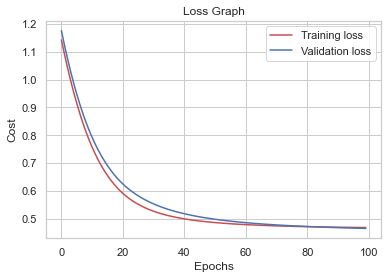

Epoch 1/100
19/19 [==============================] - 1s 21ms/step - loss: 1.1433 - auc: 0.3657 - val_loss: 1.1762 - val_auc: 0.3111
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0915 - auc: 0.3781 - val_loss: 1.1238 - val_auc: 0.3225
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0427 - auc: 0.3914 - val_loss: 1.0750 - val_auc: 0.3389
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9970 - auc: 0.4072 - val_loss: 1.0297 - val_auc: 0.3550
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9546 - auc: 0.4244 - val_loss: 0.9874 - val_auc: 0.3789
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9150 - auc: 0.4423 - val_loss: 0.9480 - val_auc: 0.3964
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.8781 - auc: 0.4634 - val_loss: 0.9117 - val_auc: 0.4164
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.8441 - 

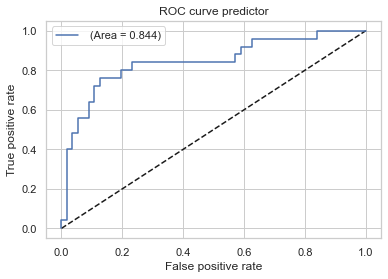

AUC 0.8435714285714285
Specificity: tf.Tensor(0.8392857127869898, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6785714261479592, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8867924511569953, shape=(), dtype=float64)


In [908]:
 aucPred, spePred, senPred, ppvPred, npvPred = predictor.fit(x_train_data, y_train_values, x_val_data, y_val_values)

## Limpiando Datos
#### Reemplazando Nulls por la mediana

Pregnancies        3.0
Glucose          118.0
BloodPressure     72.0
SkinThickness     29.0
BMI               32.3
dtype: float64
Pregnancies        3.0
Glucose          118.0
BloodPressure     72.0
SkinThickness     29.0
BMI               32.3
dtype: float64
Pregnancies        3.0
Glucose          118.0
BloodPressure     72.0
SkinThickness     29.0
BMI               32.3
dtype: float64
INFO:tensorflow:Reloading Oracle from existing project saved_models\rep_nulls_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rep_nulls_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


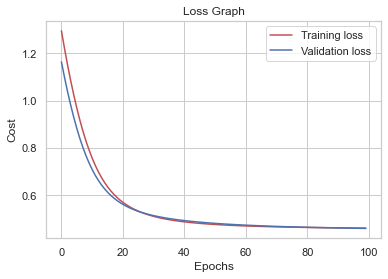

Epoch 1/100
19/19 [==============================] - 1s 25ms/step - loss: 1.2951 - auc: 0.3225 - val_loss: 1.1639 - val_auc: 0.2686
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 1.2206 - auc: 0.3336 - val_loss: 1.0987 - val_auc: 0.2846
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1507 - auc: 0.3461 - val_loss: 1.0381 - val_auc: 0.3054
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0856 - auc: 0.3596 - val_loss: 0.9816 - val_auc: 0.3225
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0245 - auc: 0.3764 - val_loss: 0.9304 - val_auc: 0.3471
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9691 - auc: 0.3972 - val_loss: 0.8834 - val_auc: 0.3739
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9180 - auc: 0.4178 - val_loss: 0.8409 - val_auc: 0.4046
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8717 - 

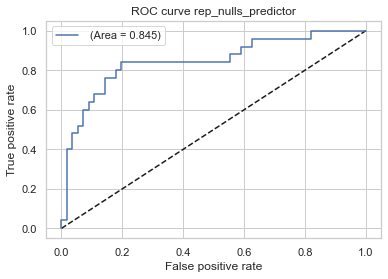

AUC 0.845
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7037037010973937, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8888888872427984, shape=(), dtype=float64)


In [910]:
predictorRepNulls = DiabetesPredictor('rep_nulls_predictor')
aucRepNulls, speRepNulls, senRepNulls, ppvRepNulls, npvRepNulls = predictorRepNulls.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])

#### Reemplazando Outliers


Trial 30 Complete [00h 00m 11s]
val_auc: 0.2574999928474426

Best val_auc So Far: 0.7704761823018392
Total elapsed time: 00h 03m 54s
INFO:tensorflow:Oracle triggered exit


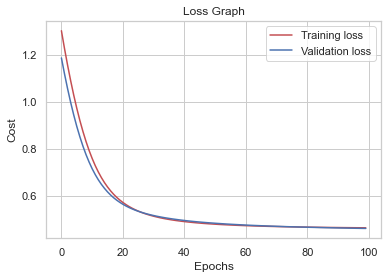

Epoch 1/100
19/19 [==============================] - 1s 20ms/step - loss: 1.3041 - auc: 0.3214 - val_loss: 1.1883 - val_auc: 0.2657
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 1.2286 - auc: 0.3320 - val_loss: 1.1205 - val_auc: 0.2811
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1577 - auc: 0.3445 - val_loss: 1.0574 - val_auc: 0.3032
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0915 - auc: 0.3580 - val_loss: 0.9988 - val_auc: 0.3204
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0298 - auc: 0.3743 - val_loss: 0.9451 - val_auc: 0.3446
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9733 - auc: 0.3932 - val_loss: 0.8965 - val_auc: 0.3686
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9219 - auc: 0.4143 - val_loss: 0.8518 - val_auc: 0.3982
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.8745 - 

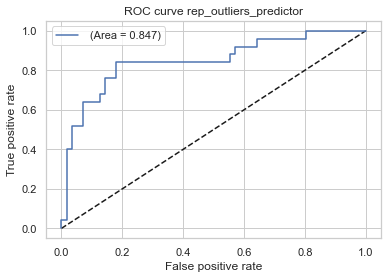

AUC 0.8471428571428571
Specificity: tf.Tensor(0.8571428556122449, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.75999999696, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7037037010973937, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8888888872427984, shape=(), dtype=float64)


In [911]:
predictorRepOutliers = DiabetesPredictor('rep_outliers_predictor')
aucRepOut, speRepOut, senRepOut, ppvRepOut, npvRepOut = predictorRepOutliers.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]})


#### Removiendo Columnas

Trial 30 Complete [00h 00m 09s]
val_auc: 0.2083333432674408

Best val_auc So Far: 0.573809544245402
Total elapsed time: 00h 03m 55s
INFO:tensorflow:Oracle triggered exit


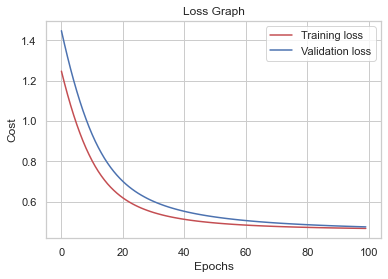

Epoch 1/100
19/19 [==============================] - 2s 28ms/step - loss: 1.2473 - auc: 0.3036 - val_loss: 1.4479 - val_auc: 0.2136
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1876 - auc: 0.3144 - val_loss: 1.3818 - val_auc: 0.2232
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 1.1317 - auc: 0.3266 - val_loss: 1.3179 - val_auc: 0.2343
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0784 - auc: 0.3397 - val_loss: 1.2578 - val_auc: 0.2507
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 1.0292 - auc: 0.3539 - val_loss: 1.2012 - val_auc: 0.2614
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9832 - auc: 0.3707 - val_loss: 1.1482 - val_auc: 0.2707
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9407 - auc: 0.3876 - val_loss: 1.0988 - val_auc: 0.2857
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.9017 - 

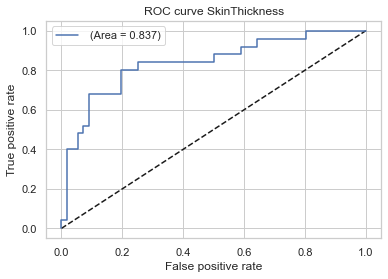

AUC 0.8371428571428572
Specificity: tf.Tensor(0.8035714271364796, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.71999999712, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6206896530321047, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8653846137204142, shape=(), dtype=float64)


In [918]:
bestAuc = aucRepOut
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in tryRemovingCols:
	print(col)
	pred = DiabetesPredictor(col)
	aucR, speR, senR, ppvR, npvR = pred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=[col])
	if (aucR>bestAuc):
		removeCols.append(col)
		removeColsAuc.append(aucR)



In [919]:
print(removeCols)
print(removeColsAuc)

['BloodPressure']
[0.8478571428571428]


INFO:tensorflow:Reloading Oracle from existing project saved_models\remColsComb\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\remColsComb\tuner0.json
INFO:tensorflow:Oracle triggered exit


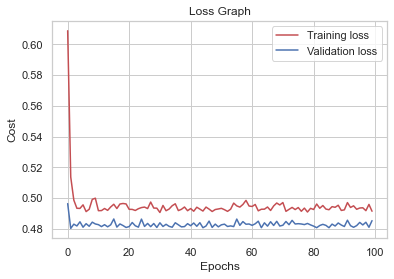

Best epoch: 2
Epoch 1/2
21/21 [==============================] - 1s 16ms/step - loss: 0.5787 - auc: 0.7094 - val_loss: 0.4961 - val_auc: 0.8112
Epoch 2/2
21/21 [==============================] - 0s 3ms/step - loss: 0.5184 - auc: 0.8178 - val_loss: 0.4832 - val_auc: 0.8081


In [40]:
remColsCombPred = DiabetesPredictor('remColsCombPred')
aucRCCP, speRCCP, senRCCP, ppvRCCP, npvRCCP = remColsCombPred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=removeCols)

#### Sacando solo Pedigree

Trial 30 Complete [00h 00m 15s]
val_loss: 0.3578888277212779

Best val_loss So Far: 0.32846153775850934
Total elapsed time: 00h 05m 06s
INFO:tensorflow:Oracle triggered exit


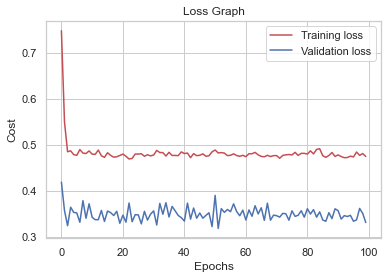

Best epoch: 52
Epoch 1/52
15/15 [==============================] - 1s 32ms/step - loss: 0.7247 - auc: 0.6742 - val_loss: 0.4432 - val_auc: 0.9000
Epoch 2/52
15/15 [==============================] - 0s 3ms/step - loss: 0.5621 - auc: 0.8138 - val_loss: 0.3439 - val_auc: 0.9067
Epoch 3/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4837 - auc: 0.8266 - val_loss: 0.3333 - val_auc: 0.9319
Epoch 4/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4789 - auc: 0.8238 - val_loss: 0.3828 - val_auc: 0.8941
Epoch 5/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4846 - auc: 0.8159 - val_loss: 0.3421 - val_auc: 0.9244
Epoch 6/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4722 - auc: 0.8280 - val_loss: 0.3458 - val_auc: 0.9176
Epoch 7/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4755 - auc: 0.8241 - val_loss: 0.3468 - val_auc: 0.9176
Epoch 8/52
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [43]:
remPedigreePred = DiabetesPredictor('remPedigreePred')
aucRPP, speRPP, senRPP, ppvRPP, npvRPP = remPedigreePred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=['DiabetesPedigreeFunction'])


### Con PolynomialFeatures

INFO:tensorflow:Reloading Oracle from existing project saved_models\featPol\oracle.json
<ipython-input-22-3f8ae0ccd5ca>:60: RuntimeWarning: invalid value encountered in true_divide
  self.x = (self.x - x_mean)/x_std
INFO:tensorflow:Reloading Tuner from saved_models\featPol\tuner0.json
INFO:tensorflow:Oracle triggered exit


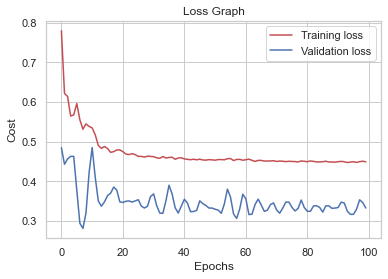

Best epoch: 8
Epoch 1/8
15/15 [==============================] - 1s 34ms/step - loss: 0.7759 - auc: 0.4782 - val_loss: 0.4819 - val_auc: 0.8941
Epoch 2/8
15/15 [==============================] - 0s 3ms/step - loss: 0.6027 - auc: 0.7855 - val_loss: 0.4485 - val_auc: 0.9042
Epoch 3/8
15/15 [==============================] - 0s 3ms/step - loss: 0.6270 - auc: 0.8159 - val_loss: 0.4803 - val_auc: 0.8899
Epoch 4/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5909 - auc: 0.8161 - val_loss: 0.4760 - val_auc: 0.8731
Epoch 5/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5736 - auc: 0.7941 - val_loss: 0.4539 - val_auc: 0.8605
Epoch 6/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5885 - auc: 0.7604 - val_loss: 0.3763 - val_auc: 0.8689
Epoch 7/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5598 - auc: 0.7797 - val_loss: 0.2954 - val_auc: 0.9160
Epoch 8/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5507 - au

In [45]:
polyPred = DiabetesPredictor('featPol')

aucPoly2, spePoly2, senPoly2, ppvPoly2, npvPoly2 = remPedigreePred.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumnsMap={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]}, columnsToRemove=['DiabetesPedigreeFunction'], polyFeatDeg=2)

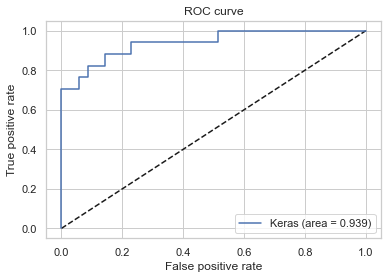

AUC 0.9394957983193277
Specificity: tf.Tensor(0.9428571401632653, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.866666660888889, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8918918894813732, shape=(), dtype=float64)


In [46]:
polyPred.plot_roc()
polyPred.get_metrics()

Trial 30 Complete [00h 00m 10s]
val_loss: 0.32692397634188336

Best val_loss So Far: 0.32231895128885907
Total elapsed time: 00h 04m 51s
INFO:tensorflow:Oracle triggered exit


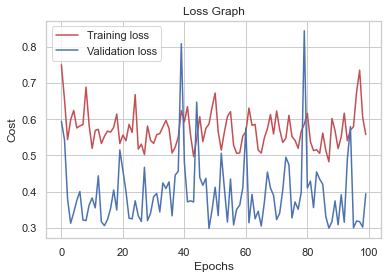

Best epoch: 49
Epoch 1/49
15/15 [==============================] - 1s 21ms/step - loss: 0.8023 - auc: 0.7383 - val_loss: 0.4148 - val_auc: 0.8832
Epoch 2/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5888 - auc: 0.7632 - val_loss: 0.3940 - val_auc: 0.8832
Epoch 3/49
15/15 [==============================] - 0s 2ms/step - loss: 0.6156 - auc: 0.7630 - val_loss: 0.4615 - val_auc: 0.8513
Epoch 4/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5520 - auc: 0.7966 - val_loss: 0.4789 - val_auc: 0.8445
Epoch 5/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5416 - auc: 0.7822 - val_loss: 0.4394 - val_auc: 0.8580
Epoch 6/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5129 - auc: 0.7992 - val_loss: 0.3970 - val_auc: 0.8941
Epoch 7/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5495 - auc: 0.7897 - val_loss: 0.4950 - val_auc: 0.8370
Epoch 8/49
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [47]:
polyPred1 = DiabetesPredictor(df, 'featPol1', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=1)
polyPred1.train_model()
aucPolyPred1 = polyPred1.validate_model()

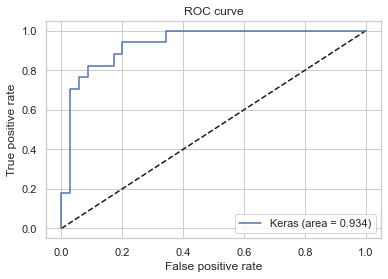

AUC 0.934453781512605
Specificity: tf.Tensor(0.9142857116734694, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.812499994921875, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.888888886419753, shape=(), dtype=float64)


In [48]:
polyPred1.plot_roc()
polyPred1.get_metrics()

INFO:tensorflow:Reloading Oracle from existing project saved_models\featPol3\oracle.json
<ipython-input-22-3f8ae0ccd5ca>:60: RuntimeWarning: invalid value encountered in true_divide
  self.x = (self.x - x_mean)/x_std
INFO:tensorflow:Reloading Tuner from saved_models\featPol3\tuner0.json
INFO:tensorflow:Oracle triggered exit


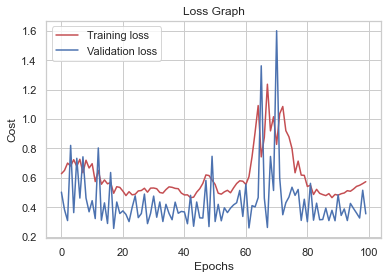

Best epoch: 18
Epoch 1/18
15/15 [==============================] - 1s 26ms/step - loss: 0.7119 - auc: 0.7194 - val_loss: 0.5722 - val_auc: 0.8655
Epoch 2/18
15/15 [==============================] - 0s 3ms/step - loss: 0.7586 - auc: 0.7146 - val_loss: 0.3556 - val_auc: 0.8807
Epoch 3/18
15/15 [==============================] - 0s 3ms/step - loss: 0.6957 - auc: 0.8023 - val_loss: 0.3890 - val_auc: 0.9168
Epoch 4/18
15/15 [==============================] - 0s 3ms/step - loss: 0.7113 - auc: 0.7776 - val_loss: 0.7393 - val_auc: 0.7513
Epoch 5/18
15/15 [==============================] - 0s 4ms/step - loss: 0.6335 - auc: 0.7846 - val_loss: 0.3212 - val_auc: 0.9235
Epoch 6/18
15/15 [==============================] - 0s 4ms/step - loss: 0.5682 - auc: 0.7963 - val_loss: 0.7093 - val_auc: 0.7277
Epoch 7/18
15/15 [==============================] - 0s 4ms/step - loss: 0.6161 - auc: 0.8003 - val_loss: 0.3627 - val_auc: 0.9353
Epoch 8/18
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [49]:
polyPred3 = DiabetesPredictor(df, 'featPol3', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2)
polyPred3.train_model()
aucPolyPred3 = polyPred3.validate_model()

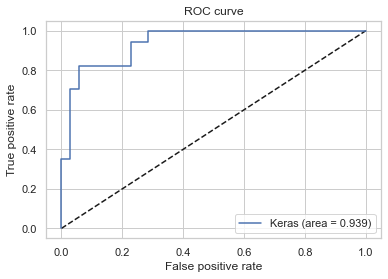

AUC 0.9394957983193277
Specificity: tf.Tensor(0.8857142831836734, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.8235294069204152, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7777777734567901, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.911764703200692, shape=(), dtype=float64)


In [50]:
polyPred3.plot_roc()
polyPred3.get_metrics()

INFO:tensorflow:Reloading Oracle from existing project saved_models\featPolBins\oracle.json
d:\Documentos\ITBA\4to año 2do cuatrimestre\Redes\TP2\env\lib\site-packages\sklearn\preprocessing\_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
<ipython-input-22-3f8ae0ccd5ca>:60: RuntimeWarning: invalid value encountered in true_divide
  self.x = (self.x - x_mean)/x_std
INFO:tensorflow:Reloading Tuner from saved_models\featPolBins\tuner0.json
INFO:tensorflow:Oracle triggered exit


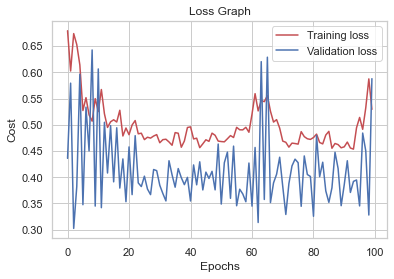

Best epoch: 3
Epoch 1/3
15/15 [==============================] - 1s 29ms/step - loss: 0.7496 - auc: 0.6835 - val_loss: 0.4654 - val_auc: 0.9059
Epoch 2/3
15/15 [==============================] - 0s 3ms/step - loss: 0.7456 - auc: 0.7545 - val_loss: 0.7016 - val_auc: 0.7849
Epoch 3/3
15/15 [==============================] - 0s 3ms/step - loss: 0.6936 - auc: 0.7690 - val_loss: 0.3277 - val_auc: 0.9193


In [51]:
polyBinsPred = DiabetesPredictor(df, 'featPolBins', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2, binsDiscretizer=5)
polyBinsPred.train_model()
aucPolyBinsPred = polyBinsPred.validate_model()

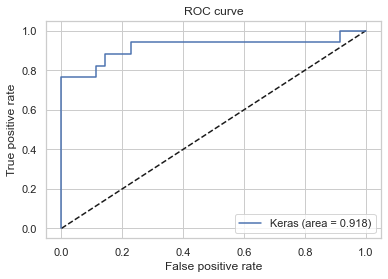

AUC 0.9176470588235295
Specificity: tf.Tensor(0.9428571401632653, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.866666660888889, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8918918894813732, shape=(), dtype=float64)


In [52]:
polyBinsPred.plot_roc()
polyBinsPred.get_metrics()